# Single-agent dynamic discrete choice estimation


This version: December 12, 2023

In [357]:
import cyipopt
%pip install pandas
%pip install matplotlib
%pip install scipy
%pip install numpy
import os
import copy
import random
import array

import numpy as np
import pandas as pd

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [358]:

import matplotlib.pyplot as plt

from scipy.optimize import minimize
from numpy.linalg import norm
from numpy import ndarray


In [359]:
from cyipopt import minimize_ipopt

# General model setup

**Reference: Chapter 2.3.1**

The model's primitives are as follows.

- Set of alternatives: $\mathcal{J} \equiv \{1, \ldots, J\}$.
- State variables: $\mathcal{S}$, with observable component $x_t \in \mathcal{X}$ and unobservable component $\epsilon_t \equiv \{\epsilon_{j,t}\}_{j \in \mathcal{J}}$.
- The discount factor: $\beta$.
- Parameter that governs the utility function: $\theta$.
- As a result, the utility of choosing action $j$ at state $s_t$ is given by
  $$
    u(s_t, j; \theta) \equiv \overline{u}_j(x_t; \theta) + \epsilon_{j,t}.
  $$
- Parameter that governs the transition probabilities: $\varphi$.

# Rust (1987)

To illustrate the estimation methods, we will use the seminal Rust (1987) bus replacement model. 

We will mostly follow the original model specifications, with a few minor changes as follows.

- Set of alternatives: $\mathcal{J} \equiv \{1, 2\}$.
  - Choice 1: maintain bus engine.
  - Choice 2: replace bus engine.
- State variables:
  - Observable state variables: $x_t \in \{1, \ldots, X\}$ are the bus mileage. In this notebook, we set $X = 10$.
  - Unobservable state variables: $\epsilon_{jt}$ are assumed to follow a mean 0 T1EV distribution for any $j \in \mathcal{J}$ and $t$.
- Discount factor is assumed to be known. We set this as $\beta = 0.95$. Note that Rust (1987) uses $\beta = 0.9999$ in his main specification.
- The deterministic component of the utility (i.e., $\overline{u}_j(x_t; \theta)$) are parameterized as
  - Choice 1: $\overline{u}_1(x_t; \theta) = \theta_1 x_t$.
  - Choice 2: $\overline{u}_2(x_t; \theta) = \theta_2$.
  - We can interpret $\theta_1$ as the maintenance cost and $\theta_2$ as the replacement cost.
- The state transition matrix are given as follows.
  - When choice 1 is chosen, the transition matrix follows a multinomial distribution with $\varphi_1 = 0.3$ and $\varphi_2 = 0.6$. The transition matrix is given by:
    $$
    \begin{pmatrix}
        \varphi_1 & \varphi_2 & 1 - \varphi_1 - \varphi_2 & 0 & 0 & \cdots & 0 & 0 \\
        0 & \varphi_1 & \varphi_2 & 1 - \varphi_1 - \varphi_2 & 0 & \cdots & 0 & 0\\
        0 & 0 & \varphi_1 & \varphi_2 & 1 - \varphi_1 - \varphi_2 & \cdots & 0 & 0 \\
        0 & 0 & 0 & 0 & 0 & \cdots & 0 & 0 \\
        \vdots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\ 
        0 & 0 & 0 & 0 & 0 & \cdots & \varphi_1 & 1 - \varphi_1 \\ 
        0 & 0 & 0 & 0 & 0 & \cdots & 0 & 1
    \end{pmatrix}
    $$
  - When choice 2 is chosen, the states are reset to the initial state.
    $$
        \begin{pmatrix}
            1 & 0 & 0 & \cdots & 0 \\
            1 & 0 & 0 & \cdots & 0 \\
            \vdots & \vdots & \vdots & \ddots & \vdots \\
            1 & 0 & 0 & \cdots & 0 
        \end{pmatrix}
    $$

# Primitive

The object `dgp` stores the model primitives. 

Since we parameterize the utility functions completely by $\theta$, the object is going to store $\theta$ instead of the entire vector of utilities.

In [360]:
class dgp:
    """Creates the primitives of the dynamic discrete choice model.
        
        Parameters
        ----------
        β : `float`
            The discount factor.
        u : `nd_array`
            A matrix of utility over all the states and choices.
        f : `nd_array`
            Transition matrices for all the actions.
        J : `int`
            Number of actions.
        dx : `int`
            Number of states.
    """
    def __init__(
        self, 
        β: float,
        u: ndarray,
        F: ndarray,
        dx: int,
        J: int):
        
        self.β = β
        self.u = u
        self.F = F
        self.dx = dx
        self.J = J

In [361]:
β = 0.999
θ = [0.2, -1,5] 
# first should be positive
# # second should be negative (to give curvature in the correct direction)
# # third should be positive -- to match simpler example
dx = 10 # chunk into 10  for number of x states. 
J = 2

In [362]:
def utility(
    x: int, 
    a: int,
    θ: list):
    """Calculates the utility at a given action and state.
        
        Parameters
        ----------
            x : `int`
                State.
            a : `int`
                Action.
            θ : `list`
                Utility parameters.
    """
    
    if a == 0:
        u = - θ[0]*x + θ[1] + (x**2)/(10000)
    elif a == 1:
        u = -θ[2] 
        
    return u

def utility_matrix(
    dx: int,
    J: int,
    θ: list):
    """Returns the matrix of utilites over all states and choices.
        
        Each row corresponds to a state.
        
        Each column corresponds to an action.
        
        Parameters
        ----------
            dx : `int`
                Number of states.
            J : `int`
                Number of actions.
            θ: `list`
                Utility parameters.
    """
    
    umat = np.zeros((dx, J))
    
    for a in range(J):
        for x in range(dx):
            umat[x, a] = utility(x, a, θ)
            
    return umat

umat = utility_matrix(dx, J, θ)

In [363]:
def transition(
    f: list,
    dx: int):
    """Creates the transition matrices.
        
       This function creates the transition matrices for both actions.
       The parameter `f` is only relevant for constructing the 
       transition matrix for the action j = 0.
       
       Parameters
       ----------
           f : `list`
               Parameters for the multinomial distribution for j = 0.
           dx : `int`
               Number of states.
    """
    
    # Initialize the two matrices
    F0 = np.zeros((dx, dx))
    F1 = copy.copy(F0)
    
    # Transition matrix for maintaining the engine
    for i in range(dx):
        if i < dx - 2:
            F0[i, i] = f[0]
            F0[i, i + 1] = f[1]
            F0[i, i + 2] = 1 - f[0] - f[1]
        elif i == dx - 2:
            F0[i, i] = f[0]
            F0[i, i + 1] = 1 - f[0]
        else:
            F0[i, i] = 1
    
    # Transition matrix for replacing the engine
    F1[:, 0] = 1
        
    return F0, F1

f = [0.3, 0.6] # keeping this the same?....
F = transition(f, dx)

In [364]:
primitive =dgp(β, umat, F, dx, J)

In [365]:
primitive.J

2

In [366]:
data = pd.read_csv('ps2_ex2.csv')

# Exercise 2.1

In [367]:
# Rename index column to 't'
data.index.name = 't'

# Add 'replace' column that's 1 when current row's milage is higher than next row's
data['action'] = (data['milage'] > data['milage'].shift(-1)).astype(int)

In [368]:
   # Get min and max of milage
min_milage = data['milage'].min()
max_milage = data['milage'].max()
    
    # Create bins
bins = pd.IntervalIndex.from_tuples([
        (min_milage + i*(max_milage-min_milage)/10, 
         min_milage + (i+1)*(max_milage-min_milage)/10) 
        for i in range(10)
    ])
    
# Assign states based on bins
data['state'] = pd.cut(data['milage'], 
                        bins=10, 
                        labels=range(0, 10)).astype(int)
    

# We make the following bins.

In [369]:
len(bins)

10

In [370]:
data.reset_index(inplace=True)

In [371]:
data['i'] = 1

In [372]:
data

,t,milage,action,state,i
0,0,23,0,0,1
1,1,31,0,1,1
2,2,36,0,1,1
3,3,46,0,2,1
4,4,56,0,2,1
...,...,...,...,...,...
4995,4995,53,0,2,1
4996,4996,60,0,2,1
4997,4997,74,0,3,1
4998,4998,91,1,4,1


# Exercise 2.3

In [373]:
def estimate_transition_maintain(data, dgp):
    """Estimated the transition matrix for maintaining bus engine.
        
        Parameters
        ----------
        data : `DataFrame`
            The data that contains the actions and states.
        dgp : `dgp`
            The primitives of the DDC model.
    """
    
    # Estimate Δstate for each of the states
    data_tmp = copy.copy(data)
    data_tmp['state_shift'] = data_tmp.groupby('i')['state'].shift(-1)
    data_tmp['state_dif'] = data_tmp['state_shift'] - data_tmp['state']
    data_sub = data_tmp.loc[(data_tmp.action == 0) & (data_tmp.t != max(data_tmp.t))]
    
    # Construct the transition matrix for a = 0
    unique_dif = pd.unique(data_sub['state_dif'])
    probs = np.zeros(len(unique_dif))
    for idu, val in enumerate(unique_dif):
        probs[idu] = np.mean(data_sub['state_dif'] == val)
        
    return probs


def estimate_transition(data, dgp):
    """Estimate the transition matrix based on the data.
    
        Parameters
        ----------
        data : `DataFrame`
            The data that contains the actions and states.
        dgp : `dgp`
            The primitives of the DDC model.
    """
    
    # Estimate the parameters of the multinomial distribution
    maintain_prob = estimate_transition_maintain(data, dgp)
    
    # Construct the transition matrix
    transition_mat = transition(maintain_prob[range(dgp.J)], dgp.dx)
    
    return transition_mat

In [374]:
t_mat = estimate_transition(data,primitive)

In [375]:
t_mat

(array([[0.43846657, 0.56000871, 0.00152472, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.43846657, 0.56000871, 0.00152472, 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.43846657, 0.56000871, 0.00152472,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.43846657, 0.56000871,
         0.00152472, 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.43846657,
         0.56000871, 0.00152472, 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.43846657, 0.56000871, 0.00152472, 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.43846657, 0.56000871, 0.00152472, 0.        ],
        [0.        , 0.    

Let's create the primitive object one-by-one. First, set $\beta = 0.9$, $\theta = (-0.2, 5)$, $|\mathcal{X}| = 10$ and $|\mathcal{J}| = 2$.

Next, we can let `utility` be the deterministic part of the utility function that depends on our pre-defined parameters $\theta$, as well as the choice and state. Since the deterministic part of the utility is completely characterized by $\theta$, $x$, and $a$, we can compute them all in advance.

Now, let's create the transition matrix, i.e., $\mathrm{Pr}[dx_{t+1}|x_t, a_t = j, \varphi]$.

With the primitive objects defined, we can pass them to the `dgp` object as follows.

# Bellman equation representation

**Reference: chapter 2.3.1.3**

- Let $\mathrm{Pr}[dx_{t+1}|x_t, a_t = j, \varphi]$ be the transition probability.
- Let $\overline{v}_j(x_t; \theta, \varphi)$ be the deterministic part of the value function for choosing choice $j$ at state $x_t$. Then, we can write
  $$
    \overline{v}_j(x_t; \theta, \varphi)
    = \overline{u}_j(x_t; \theta) + 
        \beta \int 
            \ln \left( \sum_{k \in \mathcal{J}}
                \exp\{\overline{v}_k(x_{t+1}; \theta, \varphi)\}
                \right) \mathrm{Pr}[dx_{t+1}|x_t, a_t = j, \varphi].
  $$
- The function `csvf_state` codes the choice-specific value function at state `x` with the given vector of value functions `V`.

# Fixed point representation


- Let $\overline{w}(x_t; \theta, \varphi) \equiv \ln(\sum_{k \in \mathcal{J}} \exp\{\overline{v}_k(x_k; \theta, \varphi)\})$.
- The fixed-point equation can be written as follows:
  $$
      \begin{pmatrix}
          \overline{v}_j(1; \theta, \varphi) \\ 
          \vdots \\
          \overline{v}_j(X; \theta, \varphi)
      \end{pmatrix}
      = 
      \begin{pmatrix}
          \overline{u}_j(1; \theta) \\ 
          \vdots \\ 
          \overline{u}_j(X; \theta)
      \end{pmatrix}
      + \beta \mathbf{P}[x_{t+1} | x_t, a_t; \varphi]
      \begin{pmatrix}
          \overline{w}(1; \theta, \varphi) \\ 
          \vdots \\ 
          \overline{w}(X; \theta, \varphi)
      \end{pmatrix},
  $$
  for each $j \in \mathcal{J}$.
- The above is a fixed-point equation. For a given guess of $\{\overline{w}(x; \theta, \varphi)\}_{x \in \mathcal{X}}$, one can update $\{\overline{v}_j(x; \theta, \varphi)\}_{j \in \mathcal{J}, x \in \mathcal{X}}$, and then update $\{\overline{w}(x; \theta, \varphi)\}_{x \in \mathcal{X}}$. One can update this via the fixed point iteration procedure.
- The function `vf` computes $\{\overline{w}(x; \theta, \varphi)\}_{x \in \mathcal{X}}$ for a given of $\{\overline{v}_j(x; \theta, \varphi)\}_{j \in \mathcal{J}, x \in \mathcal{X}}$.

In [376]:
def csvf_state(dgp, V, x):
    """Choice-specific value function at a particular state.
        
        Parameters
        ----------
            dgp : `dgp`
                The primitive of the DDC model.
            V : `ndarray`
                A vector of value function.
            x : `int`
                State.
    """
    
    w = [dgp.u[x, a] + dgp.β * np.matmul(dgp.F[a][x, :], V) for a in range(dgp.J)]
    
    return w

def csvf(dgp, V):
    """Choice-specific value functions across all states.
    
        The function stacks the output of `csvf_state` over all states.
        
        Parameters
        ----------
            dgp : `dgp`
                The primitive of the DDC model.
            V : `ndarray`
                A vector of value function.
    """
    
    wmat = np.zeros((dgp.dx, dgp.J))
    
    for x in range(dgp.dx):
        wmat[x, :] = csvf_state(dgp, V, x)    
    
    return wmat

def vf(w):
    """Computes the integrated value function.
    
        This function computes the integrated value function based on the 
        choice-specific value functions.
        
        Parameters
        ----------
            w : `ndarray`
                A vector of value functions.
    """
    
    wmax = np.amax(w)
    v = np.log(np.exp(w[:, 0] - wmax) + np.exp(w[:, 1] - wmax))
    v += wmax
    
    return v

With the value functions being coded, we can code the value function iteration procedure that find the fixed point $\{\overline{w}(x; \theta, \varphi)\}_{x \in \mathcal{X}}$. 

In [377]:
def vfi(dgp, ϵ = 1e-8):
    """Value function iteration.
        
        Takes the DGP object and returns the fixed-point of the value function equation.
        
        Parameters
        ----------
            dgp : `dgp`
                The primitives of the DDC model.
            ϵ : `float`
                The tolerance level.
    """
    
    # Initialize - construct utility, transition matrices, and value function
    V0 = np.zeros(dgp.dx)

    # Iterate until convergence
    gap = 10000.
    iter = 1
    while gap > ϵ:
        w = csvf(dgp, V0)
        V1 = vf(w)
        gap = norm(V0 - V1)
        V0 = V1
        iter += 1
        
    return V0

We can get the value function using the model primitives as follows.

In [378]:
v_true = vfi(primitive)

In [379]:
v_true

array([-1604.71941339, -1605.54335436, -1606.17041842, -1606.63738021,
       -1606.98219919, -1607.2374553 , -1607.42791053, -1607.57091639,
       -1607.67677827, -1607.74940202])

# Conditional choice probability

- Under the assumption that $\epsilon_{jt}$ follows a mean 0 T1EV distribution, the conditional choice probability of choosing $j \in \mathcal{J}$ at state $x_t \in \mathcal{X}$ is
  $$
        \mathrm{Pr}[a_t = j | x_t; \theta, \varphi]
        = 
        \frac{\exp\{\overline{v}_j(x_t; \theta, \varphi)\}}{
        \sum_{k\in \mathcal{J}} \exp\{\overline{v}_k(x_t; \theta, \varphi)\}}.
  $$

In [380]:
def prob_from_dgp(dgp, V):
    """Conditional choice probability of maintaining the engine.
    
        Compute the conditional choice probability for maintaining the engine.
        
        Parameters
        ----------
            dgp : `dgp`
                The primitives of the DDC model.
            V : `ndarray`
                A vector of value functions.
    """
    
    # Compute the choice probability and take the difference
    w = csvf(dgp, V)
    wmax = np.amax(w)
    wdifexp = np.exp(w - wmax)
    
    # Compute the conditional choice probability
    prob = np.zeros((dgp.dx, dgp.J))
    wsum = np.sum(wdifexp, axis = 1)
    for a in range(dgp.J):
        prob[:, a] = wdifexp[:, a]/wsum
        
    return prob

We can compute the probability of maintaining the engine as follows.

In [381]:
prob_true = prob_from_dgp(primitive, v_true)
prob_maintain_true = prob_true[:, 0]

In [382]:
prob_maintain_true

array([0.96646886, 0.92356691, 0.85690915, 0.77175   , 0.67777164,
       0.58407015, 0.49680798, 0.41944897, 0.35461982, 0.30600599])

Let's estimate the probability of maintaining the engine based on the simulated data. The following function estimates the probability using the simple frequency estimator.

In [383]:
def estimate_ccp(data, dgp):
    """Estimates conditional choice probability of maintaining the engine
        This is estimated using the simple frequency estimator.
        
        Parameters
        ----------
        data : `DataFrame`
            The data that contains the actions and states.
        dgp : `dgp`
            The primitives of the DDC model.
    """
    
    phat = np.zeros((dgp.dx, dgp.J))
    
    for x in range(dgp.dx):
        data_x = data.loc[(data.t > 0) & (data.state == x)]
        for a in range(dgp.J):
            phat[x, a] = np.mean(data_x.action == a)
    
    return phat

In [384]:
phat = estimate_ccp(data, primitive)
phat_maintain = phat[:, 0]

# This looks wrong.. although we did have to guess the primitives for theta so..

In [385]:
phat_maintain

array([1.        , 0.9989154 , 0.98403649, 0.94366197, 0.86046512,
       0.78085106, 0.66923077, 0.55208333, 0.54166667, 0.14285714])

Let's compare the probability of choosing engine replacement from the simulated data against the probability specified by the model primitives.

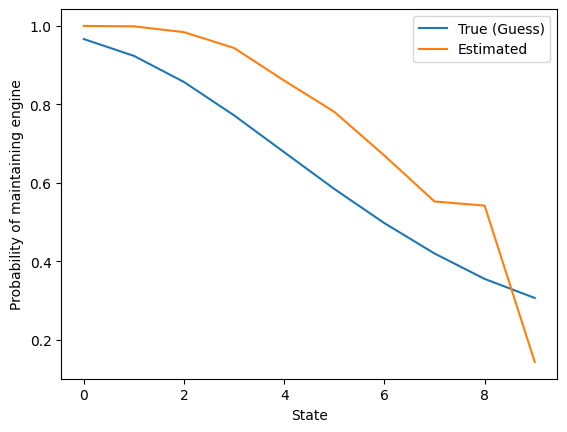

In [386]:
fig, ax = plt.subplots()  
xs = range(primitive.dx)
ax.plot(xs, prob_maintain_true, label = 'True (Guess)')
ax.plot(xs, phat_maintain, label = 'Estimated')
ax.set_xlabel('State') 
ax.set_ylabel('Probability of maintaining engine')
ax.legend()

# Estimation 1: Nested fixed-point algorithm

The nested fixed-point algorithm (NFXP) contains two loops. 
- **Outer loop**: For a given vector of value functions $V$, find $\widehat\theta$ that maximizes the likelihood.
- **Inner loop**: For a given utility parameter $\theta$, find $\widehat{V}$ the fixed-point.

Here, we estimate the transition matrix first, and then take it as given when running NFXP. Hence, we will be maximizing the (partial) log-likelihood instead of the full log-likelihood.

The function to estimate the transition matrix is as follows.

The estimation procedure is coded as follows.

In [ ]:
def likelihood_nfxp(θ, data, dgp):
    """The likelihood function for NFXP.
        
        Parameters
        ----------
        θ : `list`
            The utility parameters.
        data : `DataFrame`
            The data that contains the actions and states.
        dgp : `dgp`
            The primitives of the DDC model.
    """
    
    # Get value functions from parameters
    dgp_tmp = copy.copy(dgp)
    dgp_tmp.u = utility_matrix(dgp.dx, dgp.J, θ)
    V = vfi(dgp_tmp)
    
    # Get the choice probabilities
    pr0 = prob_from_dgp(dgp_tmp, V)
  #  print("pr0")
  #  print(pr0)
    # Compute likelihood of data
    l = likelihood(data, dgp_tmp, pr0)
    
    return l

def likelihood(data, dgp, prob):
    """The likelihood function with the given choice probability
    
        Parameters
        ----------
        data : `DataFrame`
            The data that contains the actions and states.
        dgp : `dgp`
            The primitives of the DDC model.
        prob : `ndarray`
            A matrix of choice probabilities.
    """
    
    # Compute likelihood of data
    N = int(max(data.i))
    T = int(max(data.t))
    print(N)
    print(T)
    l = 0.
   # print("line 46")
    for i in range(N):
        for t in range(T):
        #    print("49")
            condn = (data.i == i + 1) & (data.t == t + 1)
            a = int(data.loc[condn].action)
            x = int(data.loc[condn].state)
       #     print("52")
            # Append the right probability depending on the choice and state
            l += np.log(prob[x, a]) 
    #print("line 55")    
    return -l/(N*T)

def nested_fixed_point(data, dgp):
    """The nested fixed-point algorithm.

        Parameters
        ----------
        data : `DataFrame`
            The data that contains the actions and states.
        dgp : `dgp`
            The primitives of the DDC model.
    """
    def ll(x):
        return likelihood_nfxp(x, data, dgp)
    θ = minimize(ll, [0.2, -1,5])
    
    return θ

Note that the procedure `nested_fixed_point` takes the transition matrices in `dgp` as given. As a result, we need to estimate the transition matrix using the given data before passing it to the function.

In [388]:
# Estimate transition matrix
primitive_hat = copy.copy(primitive)
primitive_hat.F = estimate_transition(data, primitive)

Let's examine the solution of the NFXP.

In [389]:
# Estimate the parameters
nfxp_out = nested_fixed_point(data, primitive_hat)
print(nfxp_out.x)

pr0
[[0.96976276 0.03023724]
 [0.92208516 0.07791484]
 [0.84585195 0.15414805]
 [0.75045258 0.24954742]
 [0.64920785 0.35079215]
 [0.55209053 0.44790947]
 [0.46434753 0.53565247]
 [0.38798258 0.61201742]
 [0.32383292 0.67616708]
 [0.27598597 0.72401403]]
1
4999


/var/folders/g9/ggrmf_5j6tx4rv5qdhs0slq40000gn/T/ipykernel_26913/2423611665.py:52: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  a = int(data.loc[condn].action)
/var/folders/g9/ggrmf_5j6tx4rv5qdhs0slq40000gn/T/ipykernel_26913/2423611665.py:53: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  x = int(data.loc[condn].state)


pr0
[[0.96976276 0.03023724]
 [0.92208516 0.07791484]
 [0.84585194 0.15414806]
 [0.75045256 0.24954744]
 [0.64920783 0.35079217]
 [0.5520905  0.4479095 ]
 [0.46434749 0.53565251]
 [0.38798255 0.61201745]
 [0.32383288 0.67616712]
 [0.27598594 0.72401406]]
1
4999
pr0
[[0.96976276 0.03023724]
 [0.92208516 0.07791484]
 [0.84585195 0.15414805]
 [0.75045258 0.24954742]
 [0.64920785 0.35079215]
 [0.55209053 0.44790947]
 [0.46434753 0.53565247]
 [0.38798258 0.61201742]
 [0.32383292 0.67616708]
 [0.27598597 0.72401403]]
1
4999
pr0
[[0.96976276 0.03023724]
 [0.92208516 0.07791484]
 [0.84585195 0.15414805]
 [0.75045258 0.24954742]
 [0.64920785 0.35079215]
 [0.55209053 0.44790947]
 [0.46434753 0.53565247]
 [0.38798258 0.61201742]
 [0.32383292 0.67616708]
 [0.27598597 0.72401403]]
1
4999
pr0
[[9.99971709e-01 2.82908821e-05]
 [1.00000000e+00 3.50828860e-10]
 [1.00000000e+00 1.51025881e-14]
 [1.00000000e+00 2.26282992e-18]
 [1.00000000e+00 1.18308040e-21]
 [1.00000000e+00 2.16400243e-24]
 [1.00000000

We can also compare the probability using the parameters implied by the NFXP against the true probabilities.

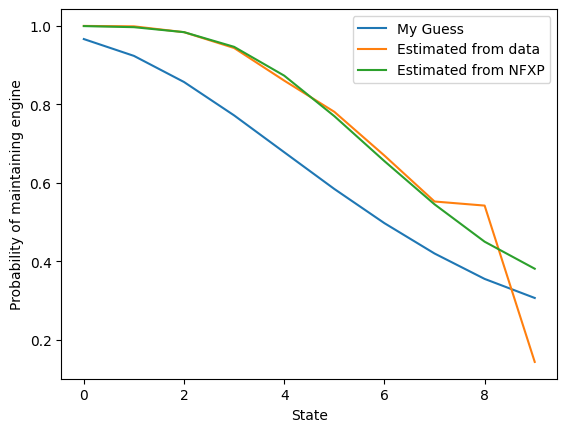

In [391]:
primitive_nfxp = copy.copy(primitive_hat)
primitive_nfxp.u = utility_matrix(dx, J, nfxp_out.x)
v_nfxp = vfi(primitive_nfxp)
p_nfxp = prob_from_dgp(primitive_nfxp, v_nfxp)

fig, ax = plt.subplots()  
xs = range(primitive.dx)
ax.plot(xs, prob_maintain_true, label = 'My Guess')
ax.plot(xs, phat_maintain, label = 'Estimated from data')
ax.plot(xs, p_nfxp[:, 0], label = 'Estimated from NFXP')
ax.set_xlabel('State') 
ax.set_ylabel('Probability of maintaining engine')
ax.legend()

# Estimation 3: Nested pseudo-likelihood

**Reference: chapter 2.3.3**

- Consider a slightly different notion of value function here together with the assumption that the error term follows a mean-0 T1EV distribution:
  $$
    \overline{\overline{v}}(x_t; \theta, \varphi)
    = \sum_{j \in \mathcal{J}}
        \text{Pr}(a_t = j|x_t; \theta, \varphi)
        \left\{
            \overline{u}_j(x_t; \theta) 
            - \ln \mathrm{Pr}(a_t = j|x_t; \theta, \varphi)
            + \beta \sum_{x' \in \mathcal{X}}
                \overline{v}(x_{t+1} = x'; \theta, \varphi)
                \text{Pr}(x_{t+1} = x'|x_t, a_t = j; \varphi)
        \right\}.
  $$

- By stacking the terms over the states and actions, we obtain a matrix equation where
  $$
    \overline{\overline{v}}(x_t; \theta, \varphi)
    = [\mathbf{I} - \beta \mathbf{P}(x_{t+1}|x_t; \theta, \varphi)]^{-1}
    \mathbf{w}(a_t, x_t; \theta, \varphi),
  $$
  where
    - $\mathbf{w}(a_t, x_t; \theta, \varphi)
        := \begin{pmatrix}
            \mathbf{p}(a_t|1; \theta, \varphi)'(\overline{\mathbf{u}}(x_t = 1; \theta) - \ln \mathbf{p}(a_t|1; \theta, \varphi) \\ 
            \mathbf{p}(a_t|2; \theta, \varphi)'(\overline{\mathbf{u}}(x_t = 2; \theta) - \ln \mathbf{p}(a_t|2; \theta, \varphi) \\ 
            \vdots \\
            \mathbf{p}(a_t|X; \theta, \varphi)'(\overline{\mathbf{u}}(x_t = X; \theta) - \ln \mathbf{p}(a_t|X; \theta, \varphi) 
        \end{pmatrix}$.
    - $\mathbf{p}(a_t|1, \theta, \varphi)
          :=
          \begin{pmatrix}
              \text{Pr}(1|1; \theta, \varphi) \\ 
              \text{Pr}(2|1; \theta, \varphi) \\
              \vdots \\ 
              \text{Pr}(J|1; \theta, \varphi)
          \end{pmatrix}$.
    - $\mathbf{P}(x_{t+1}|1, a_t; \varphi)
          :=
          \begin{pmatrix}
             \text{Pr}(1|1,1;\varphi) & 
             \text{Pr}(2|1,1;\varphi) & 
             \cdots & 
             \text{Pr}(X|1,1;\varphi) \\ 
             \text{Pr}(1|1,2;\varphi) & 
             \text{Pr}(2|1,2;\varphi) & 
             \cdots & 
             \text{Pr}(X|1,2;\varphi) \\
             \vdots & \vdots & \ddots & \vdots \\
             \text{Pr}(1|1,J;\varphi) & 
             \text{Pr}(2|1,J;\varphi) & 
             \cdots & 
             \text{Pr}(X|1,J;\varphi) 
          \end{pmatrix}
          $.
- The $K$-stage policy iteration estimator works as follows. Let $\mathbf{P}^{K-1}(a_t|x_t; \theta, \widehat{\varphi})$ be the guess of $\mathbf{P}$ in the $(K-1)$-th step. With the given guess, we want to obtain
  $$
    \widehat{\theta}^K
    = \text{arg max}_{\theta} \prod_i
        \mathcal{L}_i\left(
            \Psi(
                \mathbf{P}^{K-1}(a_t|x_t; \theta, \widehat\varphi)
            )
        \right),
  $$
  where $\mathcal{L}_i(\cdot)$ denotes the likelihood induced by the argument. The second step is to update $\mathbf{P}$ via
  $$
    \mathbf{P}^K(a_t|x_t;\theta,\widehat{\varphi})
    = \Psi(\mathbf{P}^{K-1}(a_t|x_t; \widehat{\theta}^K, \widehat{\varphi}).
  $$

In [ ]:
def estimate_unconditional_transition(dgp, phat):
    """Estimate the unconditional transition matrix.
    
        Parameters
        ----------
        dgp : `dgp`
            The primitives of the DDC model.
        phat : `ndarray`
            The matrix of estimated choice probabilities.
    """

    P = np.zeros((dgp.dx, dgp.dx))
    for a in range(dgp.J):
        P += dgp.F[a] * np.transpose([phat[:, a] for i in range(dgp.dx)])# Note: this is incorrect???
        
    return P

def nested_pseudo_likelihood_k(dgp, phat):
    """Step k of the nested pseudo likelihood method.
    
        Parameters
        ----------
        dgp : `dgp`
            The primitives of the DDC model.
        phat : `ndarray`
            The matrix of estimated choice probabilities.
    """
        
    # Get the "w" function
    what = np.sum(phat * (dgp.u - np.log(phat)), axis = 1)
    
    # Compute \bar{V} for the value function
    I = np.eye(dgp.dx)
    P = estimate_unconditional_transition(dgp, phat)
    inv_factor = np.linalg.inv(I - dgp.β * P)
    vbar = inv_factor @ what
    
    # Recover the choice-specific value function
    pnew = prob_from_dgp(dgp, vbar)
    
    return pnew


The likelihood for the nested pseudo likelihood method uses the updated $\widehat P^K$ to construct an updated $\widehat V^K$, which is subsequently used to construct the choice probability in the objective. 

In [ ]:
def likelihood_npl(θ, data, dgp, phat):
    """The likelihood function for the two-step method.
        
        Parameters
        ----------
        θ : `list`
            The utility parameters.
        data : `DataFrame`
            The data that contains the actions and states.
        dgp : `dgp`
            The primitives of the DDC model.
        phat : `ndarray`
            The matrix of estimated choice probabilities.
    """
    # Get the utility function based on the parameters
    dgp_tmp = copy.copy(dgp)
    dgp_tmp.u = utility_matrix(dgp.dx, dgp.J, θ)
    
    # Get the probability
    pk = nested_pseudo_likelihood_k(dgp_tmp, phat)
        
    # Compute likelihood of data
    l = likelihood(data, dgp_tmp, pk)
    
    return l

def nested_pseudo_likelihood(data, dgp, phat, K):
    """Run the nested pseudo likelihood method with K iterations.
        
        Parameters
        ----------
        data : `DataFrame`
            The data that contains the actions and states.
        dgp : `dgp`
            The primitives of the DDC model.
        phat : `ndarray`
            The matrix of estimated choice probabilities.
        K : `int`
            The number of iterations for the nested pseudo likelihood method.
    """
    
    pk = copy.copy(phat)
    dgpk = copy.copy(dgp)
    
    for i in range(K):
        
        def ll(x):
            return likelihood_npl(x, data, dgpk, pk)
        θiter = minimize(ll, [0.1, 0.1]).x
        
        dgpk.u = utility_matrix(dgp.dx, dgp.J, θiter)
        
        pk = nested_pseudo_likelihood_k(dgpk, pk)
        
        if i == K - 1:
            return pk, θiter

Let's see the result when we iterate it for $K=10$ times.

In [ ]:
K = 10
npl_out = nested_pseudo_likelihood(df, primitive_hat, phat, 10)
npl_out[1]

# Estimation 4: MPEC

**Reference: chapter 2.3.1.4**

The problem can be implemented as a constrained optimization problem, where we maximize the likelihood subject to the value functions as constraints.

Gradients can be passed explicitly to the above solver to reduce computational time.